# CS 162 Scheduling Lab

In [616]:
from collections import deque
from xmlrpc.client import MAXINT

import matplotlib.pyplot as plt
import numpy as np
from random import expovariate

from webcolors import IntegerRGB
%matplotlib inline

import doctest
def test(fun, verbose=False): # verbose: decide whether to print detailed run information during scheduling
    doctest.run_docstring_examples(fun, None, name=fun.__name__, verbose=verbose)

## Task Model

Our model of a task ignores what computation and I/O it actually does; we are only interested in its scheduling events.  This is captured by three basic parameters, all of which operate in an abstract time unit, say ms:

* arrival - the time at which the task is first initiated
* total - total execution time of the task (how long it runs).  Generally we don't know this value, although to simulate oracle scheduling we could peek.  It determines when the task exits.
* burst_fun - a function that returns the length of the next CPU burst, given its elapsed execution time.  This can be viewed as the time to the next syscall.  A value of 0 is taken to be run-to-completion.  A periodic application simply returns a constant, the number of time units in each burst duration.  A stochastic model is obtained by drawing a value according to some distribution.
* io_burst_fun - a function that returns the length of time the task spends waiting for I/O etc.



The overall workload is described by a stream of such tasks.

In [617]:
class Task(object):
    """ Model of a program task: 
    arrives as a certain time and then alternates CPU and IO bursts of possibly varying length
    till it has executed for a certain amount of CPU time
    """
    task_number = 0   # Unique identifier for each task
    
    def __init__(self, arrival, total, burst_fun, io_burst_fun):
        """Create a task with specified arrival, total run time, and functions modeling burst lengths."""
        Task.task_number += 1
        self.task = Task.task_number
        self.arrival_time = arrival
        self.total_run_time = total
        self.cpu_burst = burst_fun
        self.io_burst = io_burst_fun
        return None
    
    def __repr__(self):
        return "Task {} arr:{} len:{}".format(self.task, self.arrival_time, self.total_run_time)

class TaskStream(object):
    """Stream of tasks arriving as time moves forward"""
    def __init__(self, tasks):
        self.tasks = sorted(tasks, key=lambda x: x.arrival_time)
    
    def next_arrival(self):
        if not self.tasks:
            return None
        return self.tasks[0].arrival_time
    
    def enter_tasks(self, time):
        """Generate a thread for and remove each tasks arriving upto time. """
        for task in self.tasks.copy():
            if task.arrival_time <= time:
                self.tasks.remove(task)
                yield Thread(task)

    def show(self):
        for t in self.tasks:
            print(t)

## Thread Model

The execution of the steps of a task is emulated by `Thread` class `run` method.  It is passed the length of the CPU quanta up to which may run, with `q == 0` indicating indefinitely, i.e., to the end of its burst or to completion.  Based on its internal bookkeeping, i.e., where the thread is in the current burst and the task time to completion, 
`run` determines how long the thread will run and returns that value along with a status indicating whether the
thread continues to run at the end of the quantum ("cpu"), blocked before the quantum ("io"), or ran to completion ("done"). 

One subtlety is that if a tasks is scheduled multiple times to complete a burst, the `burst_fun` is not used until the task is rescheduled after the completes, i.e., it would be returning from the syscall.

In [618]:
class Thread(object):
    """ Model of a running process thread.
    
    Each time a task is run, it executes for 1 or more time units, until it
    - completes a cpu burst
    - exhausts a quanta (under preemptive scheduling), or
    - completes
    """
    
    def __init__(self, task):
        """Create a thread object with characteristics of modeled task."""
        self.task = task
        self.elapsed_time = 0
        self.last_queued = None
        self.wait_time = 0
        self.remaining_burst = None
        self.wakeup_time = None
    
    def __repr__(self):
        return "Thread {} | elapsed: {} wait:{} rbrst:{} wakeup: {}".format(self.task, 
                                    self.elapsed_time, self.wait_time, self.remaining_burst, self.wakeup_time)
        
    def remaining(self):
        return self.task.total_run_time - self.elapsed_time
    
    def run(self, q=0):
        """ Advance the thread for up to q units (q==0 is nonpreemptive) till cpu burst completes or done"""
        io_time = None
        if (self.remaining_burst):  # Still completing burst
            if q > 0:                 # preemptive : run for Q, burst done, or pgm done
                run_len = min(q, self.remaining_burst, self.remaining())
            else:                      # non-preemptive : run till burst or pgm down
                run_len = min(self.remaining_burst, self.remaining())
            self.remaining_burst -= run_len
            self.elapsed_time += run_len
            if self.remaining_burst:                    # Still working on prior CPU burst
                status = 'cpu'
            else:
                status = 'io'                            # completed the burst, start wait
                io_time = self.task.io_burst(self.elapsed_time) 
        else:                                                             # starting a new burst
            burst = self.task.cpu_burst(self.elapsed_time)   
            if burst == 0 and q == 0:                                # run till done
                run_len = self.remaining()           
            elif burst == 0:                                           # run till Q or done
                run_len = min(q, self.remaining())  
            elif q == 0:                                               # run till burst or done
                run_len = min(burst, self.remaining())
            else:                                                         # run till Q, burst, or done
                run_len = min(q, burst, self.remaining())

            self.elapsed_time += run_len
            if burst == 0:
                status = 'cpu'
            elif run_len < burst:                           # Continue CPU burst
                self.remaining_burst = burst - run_len
                status = 'cpu'
            else:                                          # Completed CPU burst, start I/O wait
                status = 'io'
                io_time = self.task.io_burst(self.elapsed_time) 

        if self.remaining() <= 0:             # override status if thread finished
            status = 'done'
        return run_len, status, io_time

## Processor  Model

We also have a very simple model of a process.  It moves forward in time, either sitting idle or executing a task.  

The one complexity is that if tasks arrive or IO completes while a thread is being run, they need to be entered into the ready queue.  Thus, our processor model needs access to the task stream and the enqueue method of the scheduler for such starts and restarts.

In [619]:
class Machine(object):
    """
    Simulate machine.  
    Time moves forward, either idling or running - this is the only property of the machine
    Along the way, it consumes the list of future tasks, builds a log of its actions,
    and records the summary of every thread.
    """
    def __init__(self, task_stream, ready, verbose=False):
        self.time = 0   
        
        self.log = [(0, 'start')]
        self.threads = []
        self.verbose = verbose
        
        self.io = []
        self.future = task_stream
        self.ready = ready
        self._arrivals()
        
    def pending(self):
        return self.future.tasks or self.io
    
    def next_start(self):
        """Return time of next start or -1 if none."""
        next_taskstart = self.future.next_arrival()
        if self.io and next_taskstart:
            return min(next_taskstart, min([t.wakeup_time for t in self.io]))
        elif self.io:
            return min([t.wakeup_time for t in self.io])
        else:
            return next_taskstart
        
    def io_wait(self, thread, wait_time):
        """ Put thread completed cpu burst with positive wait time in IO queue till wakeup"""
        thread.wakeup_time = self.time + wait_time
        self.io.append(thread)
        if self.verbose:
            print("{0}: IO wait for Task {1} for duration {2}".format(self.time, thread.task.task, wait_time))
        self.log.append((self.time, 'io wait', thread.task, wait_time))

    def _arrivals(self):
        # Collect new tasks that arrived while this was idling or running
        for thread in self.future.enter_tasks(self.time):
            self.threads.append(thread)
            self.ready.arrive(thread, thread.task.arrival_time)
            if self.verbose:
                print("{0}: Arrival of Task {1} (ready queue length = {2})".format(thread.task.arrival_time, thread.task.task, len(self.ready)))
            self.log.append((thread.task.arrival_time, 'arrive', thread.task, len(self.ready)))
            
        # Collect threads that completed IO
        for thread in self.io.copy():
            if thread.wakeup_time <= self.time:
                self.io.remove(thread)
                self.ready.wake(thread, thread.wakeup_time)
                if self.verbose:
                    print("{0}: Wakeup of Task {1} (ready queue length = {2})".format(thread.wakeup_time, thread.task.task, len(self.ready)))
                self.log.append((thread.wakeup_time, 'wakeup', thread.task, len(self.ready)))
            
    
    def idle(self):
        """
        Idle from current time till next task arrival or IO wait completes.  
        Enter all tasks that arrive or IO complete during idle period ready queue.
        """
        if self.pending():
            idle_time = self.next_start()
            if idle_time > 0:
                if self.verbose:
                    print("{0}: Idle for {1}".format(self.time, idle_time - self.time))
                self.log.append((self.time, 'idle', idle_time - self.time))
                self.time = idle_time          # Processor moves forward in time
                self._arrivals()    
    
    def run(self, run_time, thread):
        """ Advance machine time for run_time.  
        Enter new tasks and IO completes during run into ready queue
        """
        if self.verbose:
            print("{0}: Run Task {1} for duration {2} (ready queue length = {3})".format(self.time, thread.task.task, run_time, len(self.ready)))
        self.log.append((self.time, 'run', thread.task, run_time, len(self.ready), self.ready.weight()))
        self.time += run_time           # All we do to run is move time forward
        self._arrivals()
            
    def stop(self):
        if self.verbose:
            print("{0}: Stop".format(self.time))
        self.log.append((self.time, 'stop'))

# Example Schedulers

Each scheduler consists of a loop over the workload and a data structure that implements its policy.  The
schedule presents the thread with its quanta to the thread model to determine how long it retains the CPU
and the status at the end of that time, i.e. CPU, I/O, Done.  

Based on that determination, it allows the machine to advance to that point in time.  Along the way, tasks
may arrive or threads may complete their I/O wait, so the machine will invoke methods in the scheduler
appropriately.

## FCFS and Round Robin

Both are built on a simple FIFO queue, the latter with preemption using fixed quanta.  The enqueue and dequeue operation take a simulated time as which it occurs so that they can update observational data carried in the task structure for analysis and reporting.

In [620]:
class FIFOQueue:
    """ FIFO Queue of tasks to be scheduled """
    def __init__(self):
        self.queue = deque()
    
    def enqueue(self, thread, at_time):
        thread.last_queued = at_time
        self.queue.appendleft(thread)
        
    def dequeue(self, at_time):
        thread = self.queue.pop()
        thread.wait_time += at_time - thread.last_queued
        return thread
    
    def arrive(self, thread, at_time):
        self.enqueue(thread, at_time)
    
    def wake(self, thread, at_time):
        self.enqueue(thread, at_time)
    
    def empty(self):
        return len(self.queue) == 0
    
    def __len__(self):
        return len(self.queue)
    
    def weight(self):
        return sum([x.task.total_run_time - x.elapsed_time for x in self.queue])
    
    def show(self):
        for e in self.queue:
            print(" ", e)
            
def scheduler(tasks, q, queue_class, verbose=False):
    remaining = TaskStream(tasks)
    ready = queue_class()
    cpu = Machine(remaining, ready, verbose)

    while not ready.empty() or cpu.next_start():
        if ready.empty():
            cpu.idle()
        else:     
            thread = ready.dequeue(cpu.time)
            run_time, status, io_time = thread.run(q)
            cpu.run(run_time, thread)
            if status == 'io' and io_time > 0:
                cpu.io_wait(thread, io_time)
            elif status != 'done':
                ready.enqueue(thread, cpu.time)    
    cpu.stop()
    return cpu
    
def round_robin(tasks, q, verbose=False):
    return scheduler(tasks, q, FIFOQueue, verbose)
    
def fcfs(tasks, verbose=False):
    return round_robin(tasks, 0, verbose)

## Helper Functions for Burst Modeling

In [621]:
# Burst functions and factories

def indefinite(run_time):
    """Run till done"""
    return 0;

def nowait(run_time):
    """No I/O wait."""
    return 0;

def make_periodic(duration):
    """Bursts of constant duration for run or io, i.e., periodic."""
    return lambda rt: duration

def make_exponential(mean_duration):
    """Bursts of duration drawn from an exponential distribution of specified mean."""
    return lambda rt: round(expovariate(1.0/mean_duration))

In [622]:
def analyze(thrds):
    """For now just print it out"""
    print("---")
    for t in thrds:
        print(t)

## Study Cases

In [623]:
Task.task_number = 0

workload1 = [
    Task(0, 4, indefinite, nowait),
    Task(1, 7, indefinite, nowait),
    Task(2, 2, make_periodic(1), make_periodic(4)),     # run 1, IO 4, run 1
    Task(3, 3, make_periodic(1), make_periodic(1))      # run 1, IO 1, run 1, IO 1, run 1
]

# Idle two short, 1 long, four short
workload2 = [
    Task(10,  30, indefinite, nowait),
    Task(20,  30, indefinite, nowait),
    Task(30, 100, indefinite, nowait),
    Task(40,  30, indefinite, nowait),
    Task(60,  30, indefinite, nowait),
    Task(80,  30, indefinite, nowait),
    Task(100,  30, indefinite, nowait)
]

workload3 = [
    Task(0, 4, make_periodic(2), make_periodic(1)),     # run 2, IO 1, run 2
    Task(1, 7, indefinite, nowait),
    Task(2, 2, make_periodic(1), make_periodic(2)),     # run 1, IO 2, run 1
    Task(3, 3, make_periodic(6), make_periodic(1))      # run 1, IO 1, run 1, IO 1, run 1
]

## Example Testing Code

In [624]:
def test_fcfs_workload1():
    """ Test FCFS on workload1
    
    >>> _ = fcfs(workload1, True)
    0: Arrival of Task 1 (ready queue length = 1)
    0: Run Task 1 for duration 4 (ready queue length = 0)
    1: Arrival of Task 2 (ready queue length = 1)
    2: Arrival of Task 3 (ready queue length = 2)
    3: Arrival of Task 4 (ready queue length = 3)
    4: Run Task 2 for duration 7 (ready queue length = 2)
    11: Run Task 3 for duration 1 (ready queue length = 1)
    12: IO wait for Task 3 for duration 4
    12: Run Task 4 for duration 1 (ready queue length = 0)
    13: IO wait for Task 4 for duration 1
    13: Idle for 1
    14: Wakeup of Task 4 (ready queue length = 1)
    14: Run Task 4 for duration 1 (ready queue length = 0)
    15: IO wait for Task 4 for duration 1
    15: Idle for 1
    16: Wakeup of Task 3 (ready queue length = 1)
    16: Wakeup of Task 4 (ready queue length = 2)
    16: Run Task 3 for duration 1 (ready queue length = 1)
    17: Run Task 4 for duration 1 (ready queue length = 0)
    18: Stop
    """
    return

In [625]:
test(test_fcfs_workload1, True)

Finding tests in test_fcfs_workload1
Trying:
    _ = fcfs(workload1, True)
Expecting:
    0: Arrival of Task 1 (ready queue length = 1)
    0: Run Task 1 for duration 4 (ready queue length = 0)
    1: Arrival of Task 2 (ready queue length = 1)
    2: Arrival of Task 3 (ready queue length = 2)
    3: Arrival of Task 4 (ready queue length = 3)
    4: Run Task 2 for duration 7 (ready queue length = 2)
    11: Run Task 3 for duration 1 (ready queue length = 1)
    12: IO wait for Task 3 for duration 4
    12: Run Task 4 for duration 1 (ready queue length = 0)
    13: IO wait for Task 4 for duration 1
    13: Idle for 1
    14: Wakeup of Task 4 (ready queue length = 1)
    14: Run Task 4 for duration 1 (ready queue length = 0)
    15: IO wait for Task 4 for duration 1
    15: Idle for 1
    16: Wakeup of Task 3 (ready queue length = 1)
    16: Wakeup of Task 4 (ready queue length = 2)
    16: Run Task 3 for duration 1 (ready queue length = 1)
    17: Run Task 4 for duration 1 (ready queue l

In [626]:
def test_round_robin() :
    """ Test round robin on workload1
    
    >>> _ = round_robin(workload1, 2, True)
    0: Arrival of Task 1 (ready queue length = 1)
    0: Run Task 1 for duration 2 (ready queue length = 0)
    1: Arrival of Task 2 (ready queue length = 1)
    2: Arrival of Task 3 (ready queue length = 2)
    2: Run Task 2 for duration 2 (ready queue length = 2)
    3: Arrival of Task 4 (ready queue length = 3)
    4: Run Task 3 for duration 1 (ready queue length = 3)
    5: IO wait for Task 3 for duration 4
    5: Run Task 1 for duration 2 (ready queue length = 2)
    7: Run Task 4 for duration 1 (ready queue length = 1)
    8: IO wait for Task 4 for duration 1
    8: Run Task 2 for duration 2 (ready queue length = 0)
    9: Wakeup of Task 3 (ready queue length = 1)
    9: Wakeup of Task 4 (ready queue length = 2)
    10: Run Task 3 for duration 1 (ready queue length = 2)
    11: Run Task 4 for duration 1 (ready queue length = 1)
    12: IO wait for Task 4 for duration 1
    12: Run Task 2 for duration 2 (ready queue length = 0)
    13: Wakeup of Task 4 (ready queue length = 1)
    14: Run Task 4 for duration 1 (ready queue length = 1)
    15: Run Task 2 for duration 1 (ready queue length = 0)
    16: Stop
    """
    return

In [627]:
test(test_round_robin, True)

Finding tests in test_round_robin
Trying:
    _ = round_robin(workload1, 2, True)
Expecting:
    0: Arrival of Task 1 (ready queue length = 1)
    0: Run Task 1 for duration 2 (ready queue length = 0)
    1: Arrival of Task 2 (ready queue length = 1)
    2: Arrival of Task 3 (ready queue length = 2)
    2: Run Task 2 for duration 2 (ready queue length = 2)
    3: Arrival of Task 4 (ready queue length = 3)
    4: Run Task 3 for duration 1 (ready queue length = 3)
    5: IO wait for Task 3 for duration 4
    5: Run Task 1 for duration 2 (ready queue length = 2)
    7: Run Task 4 for duration 1 (ready queue length = 1)
    8: IO wait for Task 4 for duration 1
    8: Run Task 2 for duration 2 (ready queue length = 0)
    9: Wakeup of Task 3 (ready queue length = 1)
    9: Wakeup of Task 4 (ready queue length = 2)
    10: Run Task 3 for duration 1 (ready queue length = 2)
    11: Run Task 4 for duration 1 (ready queue length = 1)
    12: IO wait for Task 4 for duration 1
    12: Run Task 2 

## Exploring Behavior on CPU-only Workloads

In [628]:
# FCFS exhibits convoy effect

fcfs_cpu = fcfs(workload2, True)
analyze(fcfs_cpu.threads)

0: Idle for 10
10: Arrival of Task 5 (ready queue length = 1)
10: Run Task 5 for duration 30 (ready queue length = 0)
20: Arrival of Task 6 (ready queue length = 1)
30: Arrival of Task 7 (ready queue length = 2)
40: Arrival of Task 8 (ready queue length = 3)
40: Run Task 6 for duration 30 (ready queue length = 2)
60: Arrival of Task 9 (ready queue length = 3)
70: Run Task 7 for duration 100 (ready queue length = 2)
80: Arrival of Task 10 (ready queue length = 3)
100: Arrival of Task 11 (ready queue length = 4)
170: Run Task 8 for duration 30 (ready queue length = 3)
200: Run Task 9 for duration 30 (ready queue length = 2)
230: Run Task 10 for duration 30 (ready queue length = 1)
260: Run Task 11 for duration 30 (ready queue length = 0)
290: Stop
---
Thread Task 5 arr:10 len:30 | elapsed: 30 wait:0 rbrst:None wakeup: None
Thread Task 6 arr:20 len:30 | elapsed: 30 wait:20 rbrst:None wakeup: None
Thread Task 7 arr:30 len:100 | elapsed: 100 wait:40 rbrst:None wakeup: None
Thread Task 8 arr

In [629]:
# Round robin services the later arriving short ones, more evenly distributing wait

rr40_CPU = round_robin(workload2, 40, True)
analyze(rr40_CPU.threads)

0: Idle for 10
10: Arrival of Task 5 (ready queue length = 1)
10: Run Task 5 for duration 30 (ready queue length = 0)
20: Arrival of Task 6 (ready queue length = 1)
30: Arrival of Task 7 (ready queue length = 2)
40: Arrival of Task 8 (ready queue length = 3)
40: Run Task 6 for duration 30 (ready queue length = 2)
60: Arrival of Task 9 (ready queue length = 3)
70: Run Task 7 for duration 40 (ready queue length = 2)
80: Arrival of Task 10 (ready queue length = 3)
100: Arrival of Task 11 (ready queue length = 4)
110: Run Task 8 for duration 30 (ready queue length = 4)
140: Run Task 9 for duration 30 (ready queue length = 3)
170: Run Task 10 for duration 30 (ready queue length = 2)
200: Run Task 11 for duration 30 (ready queue length = 1)
230: Run Task 7 for duration 40 (ready queue length = 0)
270: Run Task 7 for duration 20 (ready queue length = 0)
290: Stop
---
Thread Task 5 arr:10 len:30 | elapsed: 30 wait:0 rbrst:None wakeup: None
Thread Task 6 arr:20 len:30 | elapsed: 30 wait:20 rbrs

In [630]:
# Round robin with short quanta causes the interactive jobs to wait

rr20_cpu = round_robin(workload2, 20, True)
analyze(rr20_cpu.threads)

0: Idle for 10
10: Arrival of Task 5 (ready queue length = 1)
10: Run Task 5 for duration 20 (ready queue length = 0)
20: Arrival of Task 6 (ready queue length = 1)
30: Arrival of Task 7 (ready queue length = 2)
30: Run Task 6 for duration 20 (ready queue length = 2)
40: Arrival of Task 8 (ready queue length = 3)
50: Run Task 7 for duration 20 (ready queue length = 3)
60: Arrival of Task 9 (ready queue length = 4)
70: Run Task 5 for duration 10 (ready queue length = 4)
80: Arrival of Task 10 (ready queue length = 5)
80: Run Task 8 for duration 20 (ready queue length = 4)
100: Arrival of Task 11 (ready queue length = 5)
100: Run Task 6 for duration 10 (ready queue length = 5)
110: Run Task 9 for duration 20 (ready queue length = 4)
130: Run Task 7 for duration 20 (ready queue length = 4)
150: Run Task 10 for duration 20 (ready queue length = 4)
170: Run Task 11 for duration 20 (ready queue length = 4)
190: Run Task 8 for duration 10 (ready queue length = 4)
200: Run Task 9 for duration 

# Problem 1: Scheduling Simulator Implementation

Complete the implementations of the SRTF and MLFQ schedulers below.

### Shortest Remaining Time First

Use our oracle knowledge of the future of each job to select the one that will finish soonest.  This inherits from the generic queue providing a specialized dequeue.

In [631]:
class SRTFQueue(FIFOQueue):
    """ Shortest remaining time first queue - with perfect knowledge """
    def dequeue(self, at_time):

        if not self.queue:
            return None

        min_remaining = min(thread.remaining() for thread in self.queue)
        # record all the thread that has the same remainin time
        candidates = [t for t in self.queue if t.remaining() == min_remaining]

        if len(candidates) == 1:
            min_thread = candidates[0]
        else:
            # Multiple candidates: Prioritize interactive tasks (with I/O)
            # Determine by checking if the cpu_burst function returns 0
            for thread in candidates:
                # Check if it's an interactive task
                if thread.remaining_burst is None:
                    # Burst not started yet. Check the next task burst
                    next_burst = thread.task.cpu_burst(thread.elapsed_time)
                    if next_burst > 0 and next_burst != float('inf'):   # interactive task
                        min_thread = thread
                        break
            else:
                # If no interactive task is found, select the first one that arrives
                min_thread = min(candidates, key=lambda x: x.task.arrival_time)

        self.queue.remove(min_thread)
        min_thread.wait_time += at_time - min_thread.last_queued
        return min_thread


def srtf(tasks, q, verbose=False):
    return scheduler(tasks, q, SRTFQueue, verbose)

In [632]:
def test_srtf1() :
    """ Test SRTF
    
    >>> _ = srtf(workload1, 2, True)
    0: Arrival of Task 1 (ready queue length = 1)
    0: Run Task 1 for duration 2 (ready queue length = 0)
    1: Arrival of Task 2 (ready queue length = 1)
    2: Arrival of Task 3 (ready queue length = 2)
    2: Run Task 3 for duration 1 (ready queue length = 2)
    3: Arrival of Task 4 (ready queue length = 3)
    3: IO wait for Task 3 for duration 4
    3: Run Task 1 for duration 2 (ready queue length = 2)
    5: Run Task 4 for duration 1 (ready queue length = 1)
    6: IO wait for Task 4 for duration 1
    6: Run Task 2 for duration 2 (ready queue length = 0)
    7: Wakeup of Task 3 (ready queue length = 1)
    7: Wakeup of Task 4 (ready queue length = 2)
    8: Run Task 3 for duration 1 (ready queue length = 2)
    9: Run Task 4 for duration 1 (ready queue length = 1)
    10: IO wait for Task 4 for duration 1
    10: Run Task 2 for duration 2 (ready queue length = 0)
    11: Wakeup of Task 4 (ready queue length = 1)
    12: Run Task 4 for duration 1 (ready queue length = 1)
    13: Run Task 2 for duration 2 (ready queue length = 0)
    15: Run Task 2 for duration 1 (ready queue length = 0)
    16: Stop
    """
    return

In [633]:
# If you implemented SRTF correctly, this test should pass
test(test_srtf1, True)

Finding tests in test_srtf1
Trying:
    _ = srtf(workload1, 2, True)
Expecting:
    0: Arrival of Task 1 (ready queue length = 1)
    0: Run Task 1 for duration 2 (ready queue length = 0)
    1: Arrival of Task 2 (ready queue length = 1)
    2: Arrival of Task 3 (ready queue length = 2)
    2: Run Task 3 for duration 1 (ready queue length = 2)
    3: Arrival of Task 4 (ready queue length = 3)
    3: IO wait for Task 3 for duration 4
    3: Run Task 1 for duration 2 (ready queue length = 2)
    5: Run Task 4 for duration 1 (ready queue length = 1)
    6: IO wait for Task 4 for duration 1
    6: Run Task 2 for duration 2 (ready queue length = 0)
    7: Wakeup of Task 3 (ready queue length = 1)
    7: Wakeup of Task 4 (ready queue length = 2)
    8: Run Task 3 for duration 1 (ready queue length = 2)
    9: Run Task 4 for duration 1 (ready queue length = 1)
    10: IO wait for Task 4 for duration 1
    10: Run Task 2 for duration 2 (ready queue length = 0)
    11: Wakeup of Task 4 (ready q

In [634]:
# Shortest Remaining Time first sets aside the long one and services all the short ones.

def test_srtf2() :
    """ Test SRTF
    
    >>> _ = srtf(workload2, 5, True)
    0: Idle for 10
    10: Arrival of Task 5 (ready queue length = 1)
    10: Run Task 5 for duration 5 (ready queue length = 0)
    15: Run Task 5 for duration 5 (ready queue length = 0)
    20: Arrival of Task 6 (ready queue length = 1)
    20: Run Task 5 for duration 5 (ready queue length = 1)
    25: Run Task 5 for duration 5 (ready queue length = 1)
    30: Arrival of Task 7 (ready queue length = 2)
    30: Run Task 5 for duration 5 (ready queue length = 2)
    35: Run Task 5 for duration 5 (ready queue length = 2)
    40: Arrival of Task 8 (ready queue length = 3)
    40: Run Task 6 for duration 5 (ready queue length = 2)
    45: Run Task 6 for duration 5 (ready queue length = 2)
    50: Run Task 6 for duration 5 (ready queue length = 2)
    55: Run Task 6 for duration 5 (ready queue length = 2)
    60: Arrival of Task 9 (ready queue length = 3)
    60: Run Task 6 for duration 5 (ready queue length = 3)
    65: Run Task 6 for duration 5 (ready queue length = 3)
    70: Run Task 8 for duration 5 (ready queue length = 2)
    75: Run Task 8 for duration 5 (ready queue length = 2)
    80: Arrival of Task 10 (ready queue length = 3)
    80: Run Task 8 for duration 5 (ready queue length = 3)
    85: Run Task 8 for duration 5 (ready queue length = 3)
    90: Run Task 8 for duration 5 (ready queue length = 3)
    95: Run Task 8 for duration 5 (ready queue length = 3)
    100: Arrival of Task 11 (ready queue length = 4)
    100: Run Task 9 for duration 5 (ready queue length = 3)
    105: Run Task 9 for duration 5 (ready queue length = 3)
    110: Run Task 9 for duration 5 (ready queue length = 3)
    115: Run Task 9 for duration 5 (ready queue length = 3)
    120: Run Task 9 for duration 5 (ready queue length = 3)
    125: Run Task 9 for duration 5 (ready queue length = 3)
    130: Run Task 10 for duration 5 (ready queue length = 2)
    135: Run Task 10 for duration 5 (ready queue length = 2)
    140: Run Task 10 for duration 5 (ready queue length = 2)
    145: Run Task 10 for duration 5 (ready queue length = 2)
    150: Run Task 10 for duration 5 (ready queue length = 2)
    155: Run Task 10 for duration 5 (ready queue length = 2)
    160: Run Task 11 for duration 5 (ready queue length = 1)
    165: Run Task 11 for duration 5 (ready queue length = 1)
    170: Run Task 11 for duration 5 (ready queue length = 1)
    175: Run Task 11 for duration 5 (ready queue length = 1)
    180: Run Task 11 for duration 5 (ready queue length = 1)
    185: Run Task 11 for duration 5 (ready queue length = 1)
    190: Run Task 7 for duration 5 (ready queue length = 0)
    195: Run Task 7 for duration 5 (ready queue length = 0)
    200: Run Task 7 for duration 5 (ready queue length = 0)
    205: Run Task 7 for duration 5 (ready queue length = 0)
    210: Run Task 7 for duration 5 (ready queue length = 0)
    215: Run Task 7 for duration 5 (ready queue length = 0)
    220: Run Task 7 for duration 5 (ready queue length = 0)
    225: Run Task 7 for duration 5 (ready queue length = 0)
    230: Run Task 7 for duration 5 (ready queue length = 0)
    235: Run Task 7 for duration 5 (ready queue length = 0)
    240: Run Task 7 for duration 5 (ready queue length = 0)
    245: Run Task 7 for duration 5 (ready queue length = 0)
    250: Run Task 7 for duration 5 (ready queue length = 0)
    255: Run Task 7 for duration 5 (ready queue length = 0)
    260: Run Task 7 for duration 5 (ready queue length = 0)
    265: Run Task 7 for duration 5 (ready queue length = 0)
    270: Run Task 7 for duration 5 (ready queue length = 0)
    275: Run Task 7 for duration 5 (ready queue length = 0)
    280: Run Task 7 for duration 5 (ready queue length = 0)
    285: Run Task 7 for duration 5 (ready queue length = 0)
    290: Stop
    """
    return

In [635]:
# If you implemented SRTF correctly, this test should pass
test(test_srtf2, True)

Finding tests in test_srtf2
Trying:
    _ = srtf(workload2, 5, True)
Expecting:
    0: Idle for 10
    10: Arrival of Task 5 (ready queue length = 1)
    10: Run Task 5 for duration 5 (ready queue length = 0)
    15: Run Task 5 for duration 5 (ready queue length = 0)
    20: Arrival of Task 6 (ready queue length = 1)
    20: Run Task 5 for duration 5 (ready queue length = 1)
    25: Run Task 5 for duration 5 (ready queue length = 1)
    30: Arrival of Task 7 (ready queue length = 2)
    30: Run Task 5 for duration 5 (ready queue length = 2)
    35: Run Task 5 for duration 5 (ready queue length = 2)
    40: Arrival of Task 8 (ready queue length = 3)
    40: Run Task 6 for duration 5 (ready queue length = 2)
    45: Run Task 6 for duration 5 (ready queue length = 2)
    50: Run Task 6 for duration 5 (ready queue length = 2)
    55: Run Task 6 for duration 5 (ready queue length = 2)
    60: Arrival of Task 9 (ready queue length = 3)
    60: Run Task 6 for duration 5 (ready queue length = 

In [636]:
# Copy-and-paste the output of this cell as your answer to Problem 1(a).
_ = srtf(workload3, 2, True)

0: Arrival of Task 12 (ready queue length = 1)
0: Run Task 12 for duration 2 (ready queue length = 0)
1: Arrival of Task 13 (ready queue length = 1)
2: Arrival of Task 14 (ready queue length = 2)
2: IO wait for Task 12 for duration 1
2: Run Task 14 for duration 1 (ready queue length = 1)
3: Arrival of Task 15 (ready queue length = 2)
3: Wakeup of Task 12 (ready queue length = 3)
3: IO wait for Task 14 for duration 2
3: Run Task 12 for duration 2 (ready queue length = 2)
5: Wakeup of Task 14 (ready queue length = 3)
5: Run Task 14 for duration 1 (ready queue length = 2)
6: Run Task 15 for duration 2 (ready queue length = 1)
8: Run Task 15 for duration 1 (ready queue length = 1)
9: Run Task 13 for duration 2 (ready queue length = 0)
11: Run Task 13 for duration 2 (ready queue length = 0)
13: Run Task 13 for duration 2 (ready queue length = 0)
15: Run Task 13 for duration 1 (ready queue length = 0)
16: Stop


### MLFQ with Two Levels

A foreground interactive queue with a small quantum and a background CPU-bound queue with a large quantum.

In [637]:
class TwoLevelFeedbackQueue(object):
    """ Dual Queue of tasks to be scheduled """
    def __init__(self, q_int, q_cpu):
        self.queue = deque()    # High-Priority Queue (Interactive)
        self.q = q_int  # High Priority Queue Quantum
        self.q_cpu = q_cpu # Low Priority Queue Quantum
        self.cpu_queue = deque() # Low-priority queue (CPU-intensive)
    
    def enqueue(self, thread, at_time):
        """Insert into interactive"""
        # YOUR CODE HERE
        thread.last_queued = at_time
        # New tasks or tasks returning from IO start from the high-priority queue
        self.queue.appendleft(thread)
        
    def enqueue_cpu(self, thread, at_time):
        """Insert into non-interactive"""
        # YOUR CODE HERE
        thread.last_queued = at_time
        self.cpu_queue.appendleft(thread)
        
    def dequeue(self, at_time):
        # YOUR CODE HERE
        if self.queue:
            thread = self.queue.pop()
            q = self.q
        else:
            thread = self.cpu_queue.pop()
            q = self.q_cpu
        thread.wait_time += at_time - thread.last_queued
        return thread, q
    
    def arrive(self, thread, at_time):
        self.enqueue(thread, at_time)
    
    def wake(self, thread, at_time):
        self.enqueue(thread, at_time)
    
    def empty(self):
        return not self.queue and not self.cpu_queue
    
    def __len__(self):
        return len(self.queue) + len(self.cpu_queue)
    
    def weight(self):
        return sum([t.remaining() for t in self.queue]) + sum([t.remaining() for t in self.cpu_queue])


def mlfq2(tasks, q1, q2, verbose=False):
    remaining = TaskStream(tasks)
    ready = TwoLevelFeedbackQueue(q1, q2)
    cpu = Machine(remaining, ready, verbose)

    while not ready.empty() or cpu.next_start():
        if ready.empty():
            cpu.idle()
        else:     
            thread, quanta = ready.dequeue(cpu.time)
            run_time, status, io_time = thread.run(quanta)
            cpu.run(run_time, thread)
            
            if status == 'io' and io_time > 0:
                cpu.io_wait(thread, io_time)
            elif status == 'cpu':
                # Time slice used up but burst not completed, downgraded to low priority queue
                ready.enqueue_cpu(thread, cpu.time)
            elif status != 'done':
                # Burst completed within the time slice, kept in the high-priority queue
                ready.enqueue(thread, cpu.time)      
    cpu.stop()
    return cpu

In [638]:
def test_mlfq21():
    """ Test MLFQ2
    
    >>> _ = mlfq2(workload1, 2, 4, True)
    0: Arrival of Task 1 (ready queue length = 1)
    0: Run Task 1 for duration 2 (ready queue length = 0)
    1: Arrival of Task 2 (ready queue length = 1)
    2: Arrival of Task 3 (ready queue length = 2)
    2: Run Task 2 for duration 2 (ready queue length = 2)
    3: Arrival of Task 4 (ready queue length = 3)
    4: Run Task 3 for duration 1 (ready queue length = 3)
    5: IO wait for Task 3 for duration 4
    5: Run Task 4 for duration 1 (ready queue length = 2)
    6: IO wait for Task 4 for duration 1
    6: Run Task 1 for duration 2 (ready queue length = 1)
    7: Wakeup of Task 4 (ready queue length = 2)
    8: Run Task 4 for duration 1 (ready queue length = 1)
    9: Wakeup of Task 3 (ready queue length = 2)
    9: IO wait for Task 4 for duration 1
    9: Run Task 3 for duration 1 (ready queue length = 1)
    10: Wakeup of Task 4 (ready queue length = 2)
    10: Run Task 4 for duration 1 (ready queue length = 1)
    11: Run Task 2 for duration 4 (ready queue length = 0)
    15: Run Task 2 for duration 1 (ready queue length = 0)
    16: Stop
    """

In [639]:
# If you implemented MLFQ2 correctly, this test should pass
test(test_mlfq21, True)

Finding tests in test_mlfq21
Trying:
    _ = mlfq2(workload1, 2, 4, True)
Expecting:
    0: Arrival of Task 1 (ready queue length = 1)
    0: Run Task 1 for duration 2 (ready queue length = 0)
    1: Arrival of Task 2 (ready queue length = 1)
    2: Arrival of Task 3 (ready queue length = 2)
    2: Run Task 2 for duration 2 (ready queue length = 2)
    3: Arrival of Task 4 (ready queue length = 3)
    4: Run Task 3 for duration 1 (ready queue length = 3)
    5: IO wait for Task 3 for duration 4
    5: Run Task 4 for duration 1 (ready queue length = 2)
    6: IO wait for Task 4 for duration 1
    6: Run Task 1 for duration 2 (ready queue length = 1)
    7: Wakeup of Task 4 (ready queue length = 2)
    8: Run Task 4 for duration 1 (ready queue length = 1)
    9: Wakeup of Task 3 (ready queue length = 2)
    9: IO wait for Task 4 for duration 1
    9: Run Task 3 for duration 1 (ready queue length = 1)
    10: Wakeup of Task 4 (ready queue length = 2)
    10: Run Task 4 for duration 1 (rea

In [640]:
# Dual queue recognizes the long one after 1st quantum and moves to the long queue
# No oracle information is needed.

def test_mlfq22():
    """ Test MLFQ2
    
    >>> _ = mlfq2(workload2, 50, 200, True)
    0: Idle for 10
    10: Arrival of Task 5 (ready queue length = 1)
    10: Run Task 5 for duration 30 (ready queue length = 0)
    20: Arrival of Task 6 (ready queue length = 1)
    30: Arrival of Task 7 (ready queue length = 2)
    40: Arrival of Task 8 (ready queue length = 3)
    40: Run Task 6 for duration 30 (ready queue length = 2)
    60: Arrival of Task 9 (ready queue length = 3)
    70: Run Task 7 for duration 50 (ready queue length = 2)
    80: Arrival of Task 10 (ready queue length = 3)
    100: Arrival of Task 11 (ready queue length = 4)
    120: Run Task 8 for duration 30 (ready queue length = 4)
    150: Run Task 9 for duration 30 (ready queue length = 3)
    180: Run Task 10 for duration 30 (ready queue length = 2)
    210: Run Task 11 for duration 30 (ready queue length = 1)
    240: Run Task 7 for duration 50 (ready queue length = 0)
    290: Stop
    """

In [641]:
# If you implemented MLFQ2 correctly, this test should pass
test(test_mlfq22, True)

Finding tests in test_mlfq22
Trying:
    _ = mlfq2(workload2, 50, 200, True)
Expecting:
    0: Idle for 10
    10: Arrival of Task 5 (ready queue length = 1)
    10: Run Task 5 for duration 30 (ready queue length = 0)
    20: Arrival of Task 6 (ready queue length = 1)
    30: Arrival of Task 7 (ready queue length = 2)
    40: Arrival of Task 8 (ready queue length = 3)
    40: Run Task 6 for duration 30 (ready queue length = 2)
    60: Arrival of Task 9 (ready queue length = 3)
    70: Run Task 7 for duration 50 (ready queue length = 2)
    80: Arrival of Task 10 (ready queue length = 3)
    100: Arrival of Task 11 (ready queue length = 4)
    120: Run Task 8 for duration 30 (ready queue length = 4)
    150: Run Task 9 for duration 30 (ready queue length = 3)
    180: Run Task 10 for duration 30 (ready queue length = 2)
    210: Run Task 11 for duration 30 (ready queue length = 1)
    240: Run Task 7 for duration 50 (ready queue length = 0)
    290: Stop
ok


In [642]:
# Copy-and-paste the output of this cell as your answer to Problem 1(b).
_ = mlfq2(workload3, 2, 4, True)

0: Arrival of Task 12 (ready queue length = 1)
0: Run Task 12 for duration 2 (ready queue length = 0)
1: Arrival of Task 13 (ready queue length = 1)
2: Arrival of Task 14 (ready queue length = 2)
2: IO wait for Task 12 for duration 1
2: Run Task 13 for duration 2 (ready queue length = 1)
3: Arrival of Task 15 (ready queue length = 2)
3: Wakeup of Task 12 (ready queue length = 3)
4: Run Task 14 for duration 1 (ready queue length = 3)
5: IO wait for Task 14 for duration 2
5: Run Task 15 for duration 2 (ready queue length = 2)
7: Wakeup of Task 14 (ready queue length = 3)
7: Run Task 12 for duration 2 (ready queue length = 3)
9: Run Task 14 for duration 1 (ready queue length = 2)
10: Run Task 13 for duration 4 (ready queue length = 1)
14: Run Task 15 for duration 1 (ready queue length = 1)
15: Run Task 13 for duration 1 (ready queue length = 0)
16: Stop


# Problem 2: Approaching 100% Utilization

In [643]:
def make_exp_arrivals(arrival_rate, service_time, n):
    """Make n tasks of exponential distributed arrival intervals and lengths"""
    arrivals = np.cumsum(np.random.exponential(1 / arrival_rate, n))
    lengths = [service_time for _ in range(n)]
    return [Task(arr, run, indefinite, nowait) for arr, run in zip(arrivals, lengths)]

In [644]:
# These functions may (or may not) be useful for you to implement

def cpuUtilization(cpulog):
    # Given the Machine's log (list of tuples), computes the average CPU utilization
    # YOUR CODE HERE
    busy_time = 0
    total_time = cpulog[-1][0]

    for i in range(0, len(cpulog)):
        event_type = cpulog[i][1]
        if event_type == 'run':
            busy_time += cpulog[i][3]

    if total_time == 0:
        return 0
    return busy_time / total_time

def responseTimes(cpulog):
    # Given the Machine's log, computes the response time of each task, and returns a list containing them
    # YOUR CODE HERE
    arrival_times = {}
    completion_times = {}

    for entry in cpulog:
        if entry[1] == 'arrive':
            task = entry[2]
            if task.task not in arrival_times:
                arrival_times[task.task] = entry[0]
        elif entry[1] == 'run':
            # Run event: Records the last run time of a task as a possible completion time
            task = entry[2]
            run_time = entry[3]
            completion_times[task.task] = entry[0] + run_time

    response_times = []
    for task_id in arrival_times:
        if task_id in completion_times:
            response_time = completion_times[task_id] - arrival_times[task_id]
            response_times.append(response_time)

    return response_times



In [645]:
# l and lmbdas are "recommended values" that you can change if desired
l = 10
lmbdas = np.array((0.2, 0.5, 0.7, 0.8, 0.9, 0.93, 0.95, 0.97, 0.99)) / l

# Decrease this when developing in case it takes too long
TRIALS = 100

response_time_medians = []
response_time_95th_percentiles = []
utilizations = []
for lmbda in lmbdas:
    trial_utilizations = []
    trial_medians = []
    trial_95ths = []
    
    for _ in range(TRIALS):
        # YOUR CODE HERE
        tasks = make_exp_arrivals(lmbda, l, 100)
        cpu = fcfs(tasks, verbose=False)

        util = cpuUtilization(cpu.log)
        trial_utilizations.append(util)

        res_times = responseTimes(cpu.log)
        if res_times:
            trial_medians.append(np.median(res_times))
            trial_95ths.append(np.percentile(res_times, 95))

    response_time_medians.append(np.mean(trial_medians))
    response_time_95th_percentiles.append(np.mean(trial_95ths))
    utilizations.append(np.mean(trial_utilizations))
    
    # This takes a while to run so this print statement lets us track progress
    print("Finished", lmbda)


Finished 0.02
Finished 0.05
Finished 0.06999999999999999
Finished 0.08
Finished 0.09
Finished 0.093
Finished 0.095
Finished 0.097
Finished 0.099


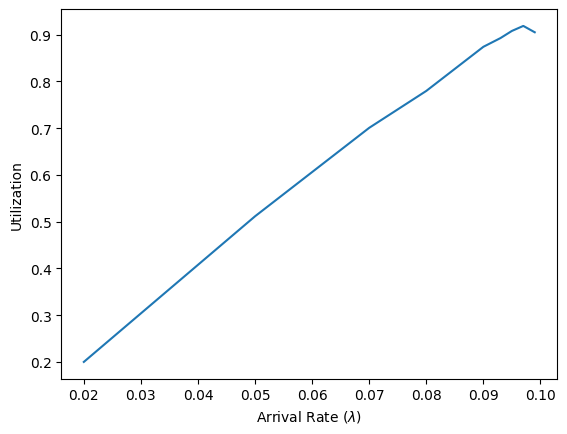

In [646]:
plt.xlabel(r"Arrival Rate ($\lambda$)")
plt.ylabel("Utilization")
plt.plot(lmbdas, utilizations)
plt.show()

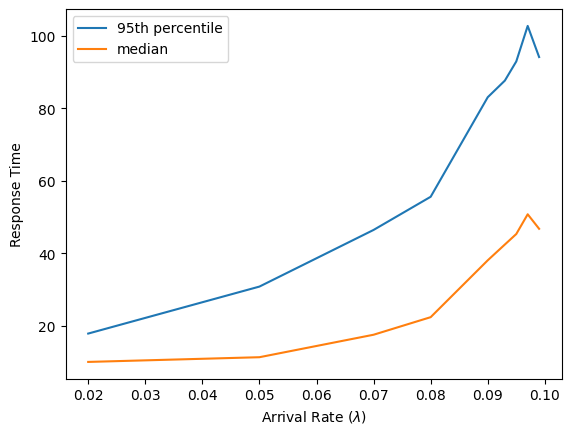

In [647]:
plt.xlabel(r"Arrival Rate ($\lambda$)")
plt.ylabel("Response Time")
plt.plot(lmbdas, response_time_95th_percentiles, label="95th percentile")
plt.plot(lmbdas, response_time_medians, label="median")
plt.legend()
plt.show()

## QUESTION
(a) Is this an open system or a closed system? Explain.

ANS: **Open system**. In this model, each CPU burst enters the system as an independent task upon arrival, executing for a fixed $T_S$ duration before leaving later. The task arrives with the parameter $\lambda$'s Poisson process (with arrival intervals following an exponential distribution) indicates that the number of tasks in the system varies over time, making it an open system.

(b) What value of λ should we choose, such that the mean time between arrivals is equal to TS? Explain.

ANS: $\lambda = \frac{1}{T_s}$. Arrival interval follows an exponential distribution, with a mean of $\frac{1}{\lambda}$. To make the average arrival interval equal to the length of the CPU burst, then it needs $\frac{1}{\lambda} = T_S$, i.e. $\lambda = \frac{1}{T_S}$

(c) What value of λ should we choose, such that the system runs at 50% utilization on average? Explain.

ANS: $\lambda = 0.5 / T_S$. Utilization rate = the ratio of busy time to total time. For such a system, if the arrival process follows a Poisson process and the service time is fixed ($T_S$), it constitutes an **M/D/1 queue** (Poisson arrival, fixed service time, single server). The utilization rate of an M/D/1 queue is $\rho = \lambda * T_S$, where $\lambda$ is the arrival rate and $T_S$ is the service time. We aim for a utilization rate of 50%. Therefore, $\rho = \lambda * T_S = 0.5 \Rightarrow \lambda = 0.5 / T_S$.

(d) As you vary $\lambda$ as described as above, what happens to CPU utilization? Show a line plot with the arrival rate on
the x axis and CPU utilization on the y axis, depicting the results.

ANS: The simulation results show that CPU utilization **increases** with the rise of arrival rate $\lambda$.  This is because:
* When $\lambda$ is small, the task arrival intervals are longer, resulting in more CPU idle time and lower utilization.
* As $\lambda$ increases, tasks arrive more frequently, the CPU becomes busier, and utilization improves.

The curve in the figure should demonstrate that the utilization rate increases monotonically with $\lambda$, eventually approaching 100%.

(e) As you vary $\lambda$ as described as above, what happens to the response time for each CPU burst? Show a line plot
with the arrival rate on the x axis and response time on the y axis, depicting the results. Be sure to consider both
the median response time and the 95th percentile.

ANS: The response time trend is:
* Median response time: remains relatively stable and low under low load (when $\lambda$ is small), increases gradually as $\lambda$ rises, and surges sharply near system capacity
* 95th percentile response time: shows a similar but more dramatic trend, slightly above the median at low load and significantly above the median at high load

This occurs because as system load increases, queues grow and wait times rise, resulting in longer response times. The 95th percentile response time reflects **the worst-case scenario**, which escalates more rapidly.

(f) Does using a different scheduler affect your answer to Part e? (Hint: If you choose to look at SRTF, think carefully
about how your implementation breaks ties and how that might affect the median response time.)

ANS: NO. When utilization approaches 100%, all schedulers exhibit a sharp increase in response time due to the infinite expansion of queues.  However, the growth rates and distributions vary among different schedulers:
* SRTF: Short tasks still achieve satisfactory response, while long tasks exhibit poor performance.
* FCFS: All task responses are extremely poor
* RR: Response time increases uniformly

(g) Qualitatively explain why running a system at close to 100% throughput results in poor latency.

ANS: When the system operates at nearly 100% throughput, the reason for a sharp increase in latency is:
* Queue theory: According to queue theory (e.g., M/M/1 queue), when the utilization rate $\rho$ approaches 1, the average queue length and waiting time tend to infinity.
* Resource contention: Under high load, tasks require longer CPU wait times, with response time primarily determined by wait time.
* Sudden accumulation: Even if the arrival process is a Poisson process, the randomness of service times may cause queues to occasionally grow longer, making them harder to dissipate under high load.
* Feedback effect: Long delays may cause retries or timeouts, further increasing the load
* Mathematical explanation: For an M/M/1 queue, the average response time $E[T] = 1/(\mu - \lambda)$, where $\mu$ denotes the service rate and $\lambda$ the arrival rate.  As $\lambda$ approaches $\mu$, the denominator approaches zero, causing the response time to approach infinity.




# Problem 3: Fairness for CPU Bursts

In [648]:
import bisect

def create_problem3_task(lmbda, num_bursts):
    # YOUR CODE HERE

    burst_lengths = np.random.exponential(1 / lmbda, num_bursts)

    total_time = np.sum(burst_lengths)

    burst_iter = iter(burst_lengths)

    def burst_fun(elapsed_time):
        try:
            return next(burst_iter)
        except StopIteration:
            return 0

    def io_fun(elapsed_time):
        return 0

    arrival_time = 0
    return Task(arrival_time, total_time, burst_fun, io_fun)

def create_problem3_workload(lmbda, num_bursts):
    task_S = create_problem3_task(lmbda, num_bursts)
    task_T = create_problem3_task(lmbda, num_bursts)
    return task_S, task_T

In [649]:
# Feel free to change this while developing if it takes too long to run
TRIALS = 10000
N = 1.1

unfair_count = 0
fair_count = 0

for _ in range(TRIALS):
    fcfs_cpu = fcfs(create_problem3_workload(1.0, 100), False)
    elapsed_0 = fcfs_cpu.threads[0].elapsed_time
    elapsed_1 = fcfs_cpu.threads[1].elapsed_time
    if elapsed_0 / elapsed_1 > N or elapsed_1 / elapsed_0 > N:
        unfair_count += 1
    else:
        fair_count += 1
        
print("Fraction of runs that were unfair:", unfair_count / (fair_count + unfair_count))

Fraction of runs that were unfair: 0.5013


## QUESTION
(a) Explain why the length of the FCFS queue never exceeds 2.

ANS: In the FCFS scheduler, tasks are served in order of arrival. Here, there are only two tasks, S and T. Each task, upon completing a CPU burst, immediately re‑enters the ready queue (since there is zero I/O time between bursts). Thus, at any moment, each task is either executing on the CPU or waiting in the ready queue. If both tasks are active (i.e., neither has finished all its bursts), one task is executing and the other is in the ready queue, so the number of waiting tasks is at most 1. If one task has finished, only one task remains, which may be either executing or waiting, giving at most one task in the ready queue. Therefore, the length of the ready queue (number of waiting tasks) never exceeds 1, and certainly never exceeds 2.

(b) What is Pr[S1 < T1]?

ANS: Since S1 and T1 are independent and identically distributed continuous random variables, by symmetry we have Pr[S1 < T1] = 1⁄2. (We assume the distribution is continuous so that Pr[S1 = T1] = 0.)

(c) Suppose S has run for m CPU bursts, where m is large. Using the Central Limit Theorem, characterize CPUTime(S),
the total CPU time spent on S, as a normal distribution parameterized by E[Si], Var(Si), and m.

ANS: Let $\mu$ = E[Si] and $\sigma^2$ = Var(Si). The total CPU time for S after m bursts is CPUTime(S) = $∑_{i=1}^m Si$. Since the Si are i.i.d., by the Central Limit Theorem, for large m, CPUTime(S) is approximately normally distributed with mean $m\mu$ and variance $m\sigma^2$:
$$\text{CPUTime}(S)∼N(m\mu,m\sigma^2)$$

(d) After the scheduler has run a large number of CPU bursts, what is Pr[n ·CPUTime(S) < CPUTime(T)]? Use your
approximation from Part c and write your answer in terms of Φ(x), the CDF of the Standard Normal Distribution.

ANS: After a large number of CPU bursts, let S have executed m bursts and T have executed n bursts. Under FCFS scheduling with zero I/O time, the two tasks alternate bursts, so m and n are nearly equal when both are large; Using the normal approximation from part (c),
$$\text{CPUTime}(S)∼N(m\mu,m\sigma^2)$$
$$\text{CPUTime}(T)∼N(n\mu,n\sigma^2)$$
and they are independent. Then the difference D = CPUTime(S) − CPUTime(T) is approximately normal with mean $(m−n)\mu$ and variance $(m+n)\sigma^2$. Thus,
$$\text{Pr}[\text{CPUTime}(S)<\text{CPUTime}(T)]=\text{Pr}[D<0]=\Phi{\left(\frac{-(m-n)\mu}{\sigma\sqrt{m+n}}\right)}=\Phi{\left(\frac{(n-m)\mu}{\sigma\sqrt{m+n}}\right)}$$
If we further assume that after a long time the scheduler has given each task approximately the same number of bursts, then
m≈n and the argument of Φ tends to zero, giving approximately $\Phi(0)=1/2$.

(e) Using software of your choice, (e.g. Maple, WolframAlpha, Python, graphing calculator), calculate the probability
that one task receives at least 10% more CPU time than the other, for m = 100. Be sure to consider both tails of
the distribution (i.e., T may get more CPU time than S OR S may get more CPU time than T). How does this
change if you use m = 10000? Was Sam’s reasoning that the CPU allocation will be fair with FCFS correct?

ANS: Assuming the CPU burst duration follows an exponential distribution with mean $\mu$ and variance $\sigma^2 = \mu²$.  Given that E[Si] = p Var(Si), we have $\mu = p\sigma^2$.  For an exponential distribution, $\sigma^2 = \mu²$, substituting yields $\mu = p\mu² \Rightarrow p = 1/\mu$.  To simplify the calculation, let $\mu$ = 1, then $\sigma$ = 1 and p = 1.

After each task completes N bursts, the total CPU time CPUTime(S) and CPUTime(T) are independent and follow a normal distribution N($\mu$, $\sigma^2$). The event 'a task gains at least 10% more CPU time' is defined as CPUTime(T) > 1.1 CPUTime(S) or CPUTime(S) > 1.1 CPUTime(T). Due to symmetry, the probability is:
$$P=2\cdot\Pr(\mathrm{CPUTime}(T)>1.1\cdot\mathrm{CPUTime}(S))$$

Define Z = CPUTime (T) - 1.1 CPUTime (S), then Z ~ N(-0.1N$\mu$, (1 + $1.1^2$) N$\sigma^2$) = N(-0.1N,2.21N).Therefore,
$$\Pr(Z>0)=1-\Phi\left(\frac{0.1N}{\sqrt{2.21N}}\right)=1-\Phi\left(\frac{0.1\sqrt{N}}{\sqrt{2.21}}\right)$$

Substitute N = 100:
$$\begin{aligned}
\frac{0.1\sqrt{100}}{\sqrt{2.21}} & =\frac{1}{1.4866}\approx0.6728,\quad\Phi(0.6728)\approx0.7495, \\
 \\
\Pr(Z>0) & \approx0.2505,\quad P\approx2\times0.2505=0.501.
\end{aligned}$$

Substitute N = 1000:
$$\begin{aligned}
\frac{0.1\sqrt{10000}}{\sqrt{2.21}} & =\frac{10}{1.4866}\approx6.728,\quad\Phi(6.728)\approx1, \\
 \\
\Pr(Z>0) & \approx0,\quad P\approx0.
\end{aligned}$$

Therefore, with a small burst count (e.g., m=100), there's a 50% chance of at least 10% unfair distribution; whereas with a large burst count (e.g., m=10000), the probability of unfairness drops to nearly zero.  Sam's reasoning holds true in the long run but may lead to significant short-term unfairness.

(f) Run a simulation in the IPython notebook to confirm your result from Part e. Describe the simulation you performed and produce a graph supporting your conclusion.

N=10: simulated 0.8385, theoretical 0.8315
N=20: simulated 0.7555, theoretical 0.7635
N=50: simulated 0.6330, theoretical 0.6343
N=100: simulated 0.4920, theoretical 0.5012
N=200: simulated 0.3435, theoretical 0.3415
N=500: simulated 0.1180, theoretical 0.1325
N=1000: simulated 0.0335, theoretical 0.0334
N=2000: simulated 0.0030, theoretical 0.0026
N=5000: simulated 0.0000, theoretical 0.0000
N=10000: simulated 0.0000, theoretical 0.0000


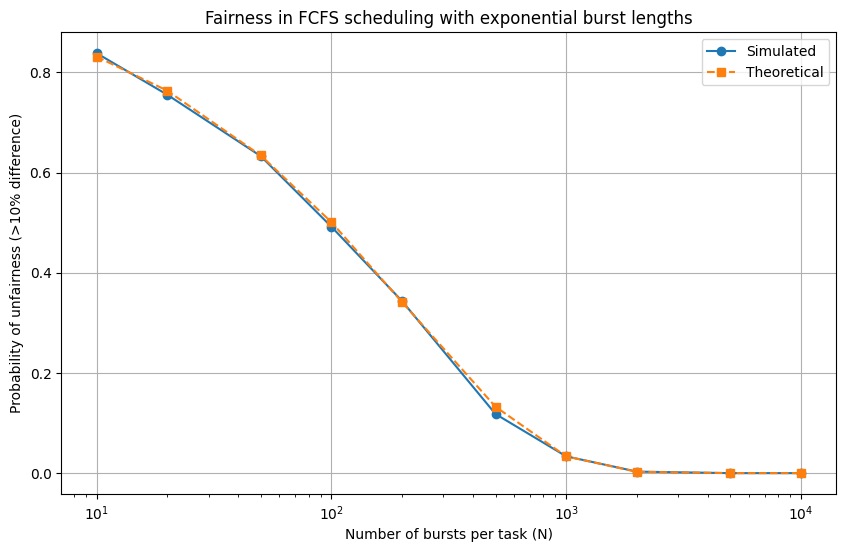

In [654]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def create_problem3_task(lmbda, num_bursts):
    burst_lengths = np.random.exponential(1/lmbda, num_bursts)
    total_time = np.sum(burst_lengths)
    burst_iter = iter(burst_lengths)
    def burst_fun(elapsed_time):
        try:
            return next(burst_iter)
        except StopIteration:
            return 0
    def io_fun(elapsed_time):
        return 0
    return Task(0, total_time, burst_fun, io_fun)

def create_problem3_workload(lmbda, num_bursts):
    return (create_problem3_task(lmbda, num_bursts),
            create_problem3_task(lmbda, num_bursts))

def simulate_unfair_probability(lmbda, num_bursts, trials=2000, threshold=1.1):
    unfair = 0
    for _ in range(trials):
        task_S, task_T = create_problem3_workload(lmbda, num_bursts)
        cpu = fcfs([task_S, task_T], verbose=False)
        t_S = cpu.threads[0].elapsed_time
        t_T = cpu.threads[1].elapsed_time
        if t_S/t_T > threshold or t_T/t_S > threshold:
            unfair += 1
    return unfair / trials

def theoretical_probability(num_bursts, threshold=1.1):
    a = threshold
    param = (a-1) * np.sqrt(num_bursts) / np.sqrt(1 + a**2)
    prob_one_side = 1 - norm.cdf(param)
    return 2 * prob_one_side


bursts_list = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
sim_probs, theo_probs = [], []
for N in bursts_list:
    print(f"N={N}: ", end='')
    sim = simulate_unfair_probability(1.0, N, trials=2000)
    sim_probs.append(sim)
    theo = theoretical_probability(N)
    theo_probs.append(theo)
    print(f"simulated {sim:.4f}, theoretical {theo:.4f}")


plt.figure(figsize=(10,6))
plt.plot(bursts_list, sim_probs, 'o-', label='Simulated')
plt.plot(bursts_list, theo_probs, 's--', label='Theoretical')
plt.xscale('log')
plt.xlabel('Number of bursts per task (N)')
plt.ylabel('Probability of unfairness (>10% difference)')
plt.title('Fairness in FCFS scheduling with exponential burst lengths')
plt.legend()
plt.grid(True)
plt.show()

(g) (Optional Stretch) How would the result be different if Sam were to use a preemptive round-robin scheduler with
a small quantum?

ANS: Under preemptive round-robin scheduling (small quantum), each task's CPU burst is divided into multiple time slices. However, the total CPU time allocated to a task remains equal to the sum of all its burst durations, regardless of the scheduling method.  Consequently, the probability distribution of total CPU time allocation mirrors that of First-Come-First-Served (FCFS), with the unfairness probability remaining unchanged.  While round-robin scheduling may bring two tasks closer in burst counts, FCFS inherently maintains nearly equal burst counts through strict alternation.  Thus, the actual outcome shows **no fundamental difference** from FCFS.

In conclusion, each task's total CPU time is the sum of all its burst lengths. Since the distributions are the same, these sums will converge to the same expected value in the long run. Scheduling algorithms only affect the order of time allocation, not the total amount.

Therefore, Sam's reasoning is essentially correct: when two tasks have the same burst length distribution, even with a simple FCFS scheduler, CPU time allocation is fair in the long run.

Run the following code to demonstrate it.

Testing with 10 bursts...
  FCFS: 0.8320, RR(small q=0.1): 0.8340, RR(large q=5.0): 0.8180
Testing with 20 bursts...
  FCFS: 0.7260, RR(small q=0.1): 0.7320, RR(large q=5.0): 0.7300
Testing with 50 bursts...
  FCFS: 0.6400, RR(small q=0.1): 0.6680, RR(large q=5.0): 0.6200
Testing with 100 bursts...
  FCFS: 0.5000, RR(small q=0.1): 0.4980, RR(large q=5.0): 0.5060
Testing with 200 bursts...
  FCFS: 0.3320, RR(small q=0.1): 0.3480, RR(large q=5.0): 0.3380
Testing with 500 bursts...
  FCFS: 0.1040, RR(small q=0.1): 0.1240, RR(large q=5.0): 0.1160
Testing with 1000 bursts...
  FCFS: 0.0280, RR(small q=0.1): 0.0260, RR(large q=5.0): 0.0340
Testing with 2000 bursts...
  FCFS: 0.0000, RR(small q=0.1): 0.0020, RR(large q=5.0): 0.0000
Testing with 5000 bursts...
  FCFS: 0.0000, RR(small q=0.1): 0.0000, RR(large q=5.0): 0.0000
Testing with 10000 bursts...
  FCFS: 0.0000, RR(small q=0.1): 0.0000, RR(large q=5.0): 0.0000


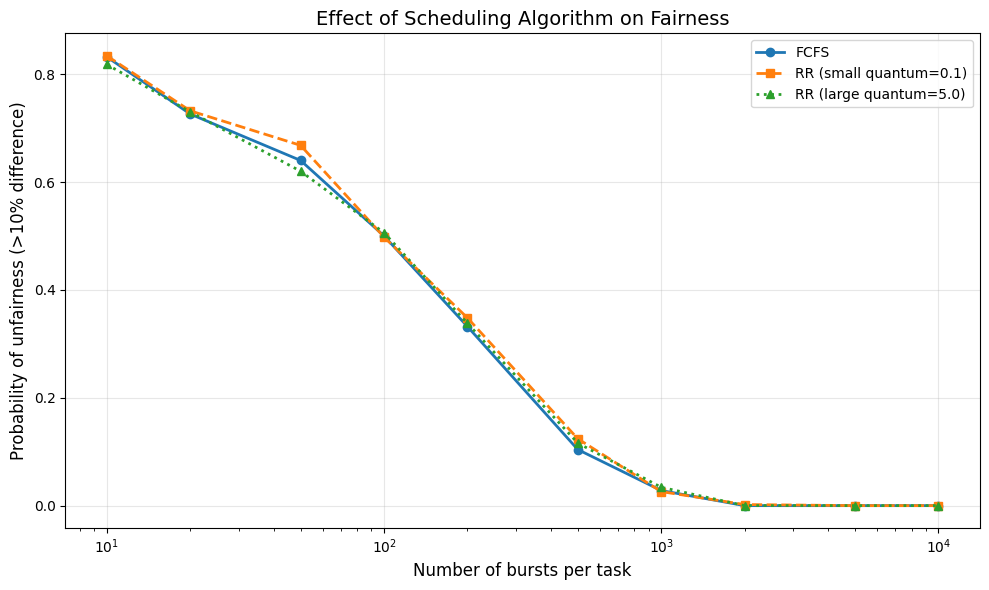

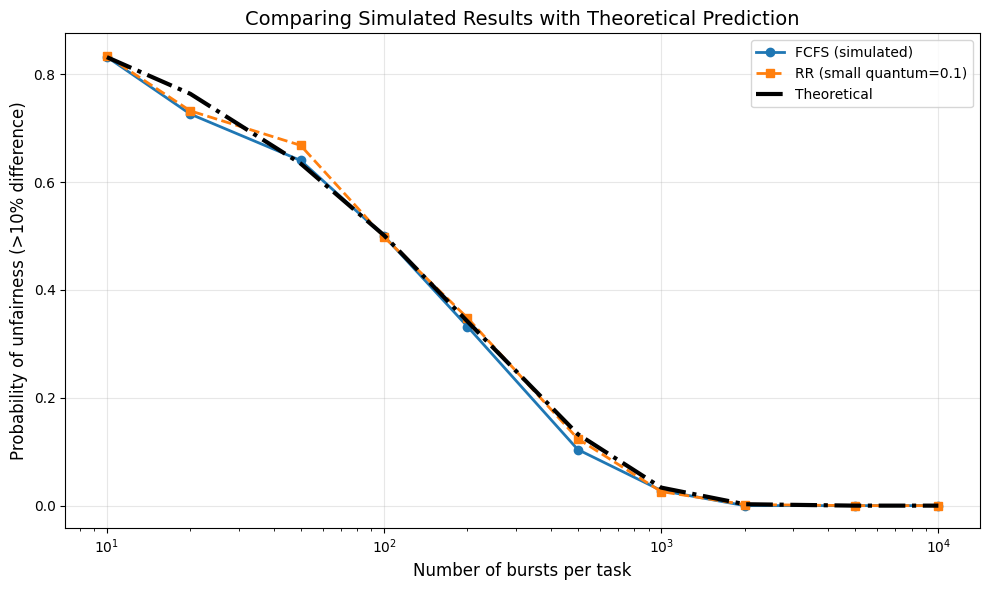

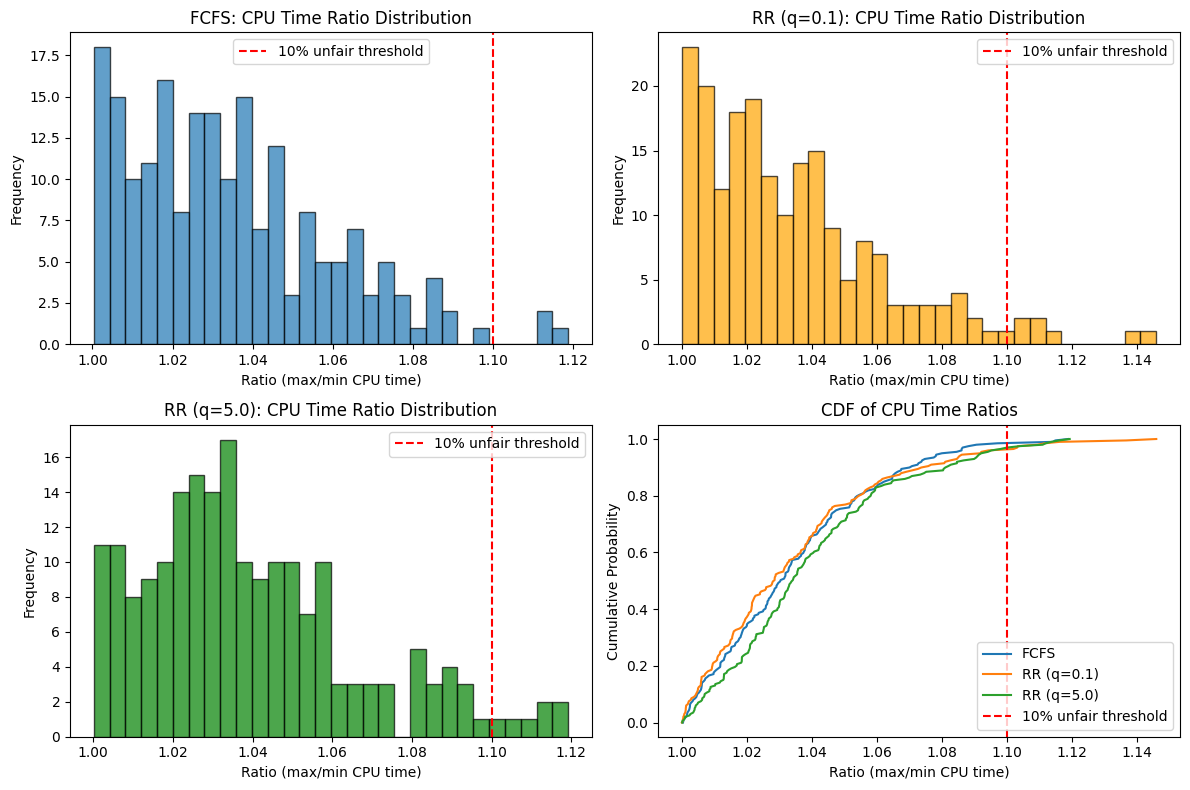


=== Statistical Summary (num_bursts=1000) ===
FCFS:
  Mean ratio: 1.0344
  Ratio standard deviation: 0.0251
  Unfair probability(>1.1): 0.0150

RR (quantum=0.1):
  Mean ratio: 1.0341
  Ratio standard deviation: 0.0284
  Unfair probability(>1.1): 0.0400

RR (quantum=5.0):
  Mean ratio: 1.0392
  Ratio standard deviation: 0.0268
  Unfair probability(>1.1): 0.0300


In [656]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# To run the verification, we need to use the existing scheduler framework
# First, ensure we have all required class definitions
def simulate_unfairness_with_scheduler(scheduler_func, lmbda=1.0, num_bursts=100,
                                      trials=1000, threshold=1.1, quantum=None):
    """Simulate unfair probability using specified scheduler"""
    unfair_count = 0

    for _ in range(trials):
        # Create two independent tasks
        burst_lengths_S = np.random.exponential(1/lmbda, num_bursts)
        burst_lengths_T = np.random.exponential(1/lmbda, num_bursts)

        # Create iterators
        def create_burst_fun(burst_lengths):
            burst_iter = iter(burst_lengths)
            def burst_fun(elapsed_time):
                try:
                    return next(burst_iter)
                except StopIteration:
                    return 0
            return burst_fun

        # Create tasks
        task_S = Task(0, np.sum(burst_lengths_S),
                     create_burst_fun(burst_lengths_S),
                     lambda rt: 0)
        task_T = Task(0, np.sum(burst_lengths_T),
                     create_burst_fun(burst_lengths_T),
                     lambda rt: 0)

        # Run with specified scheduler
        if quantum:
            cpu = scheduler_func([task_S, task_T], quantum, verbose=False)
        else:
            cpu = scheduler_func([task_S, task_T], verbose=False)

        # Get total CPU time
        elapsed_S = cpu.threads[0].elapsed_time
        elapsed_T = cpu.threads[1].elapsed_time

        # Check if unfair
        if elapsed_S / elapsed_T > threshold or elapsed_T / elapsed_S > threshold:
            unfair_count += 1

    return unfair_count / trials

# Test performance of different schedulers
bursts_list = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
threshold = 1.1  # 10% unfair threshold

results_fcfs = []
results_rr_small = []
results_rr_large = []

for num_bursts in bursts_list:
    print(f"Testing with {num_bursts} bursts...")

    # FCFS (quantum=0, non-preemptive)
    p_fcfs = simulate_unfairness_with_scheduler(
        fcfs, num_bursts=num_bursts, trials=500, threshold=threshold
    )
    results_fcfs.append(p_fcfs)

    # Round Robin with small quantum (quantum=0.1)
    p_rr_small = simulate_unfairness_with_scheduler(
        round_robin, num_bursts=num_bursts, trials=500,
        threshold=threshold, quantum=0.1
    )
    results_rr_small.append(p_rr_small)

    # Round Robin with large quantum (quantum=5.0)
    p_rr_large = simulate_unfairness_with_scheduler(
        round_robin, num_bursts=num_bursts, trials=500,
        threshold=threshold, quantum=5.0
    )
    results_rr_large.append(p_rr_large)

    print(f"  FCFS: {p_fcfs:.4f}, RR(small q=0.1): {p_rr_small:.4f}, RR(large q=5.0): {p_rr_large:.4f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(bursts_list, results_fcfs, 'o-', label='FCFS', linewidth=2)
plt.plot(bursts_list, results_rr_small, 's--', label='RR (small quantum=0.1)', linewidth=2)
plt.plot(bursts_list, results_rr_large, '^:', label='RR (large quantum=5.0)', linewidth=2)

plt.xscale('log')
plt.xlabel('Number of bursts per task', fontsize=12)
plt.ylabel('Probability of unfairness (>10% difference)', fontsize=12)
plt.title('Effect of Scheduling Algorithm on Fairness', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Add theoretical curve for comparison
def theoretical_probability(num_bursts, threshold=1.1):
    """Theoretical unfair probability"""
    a = threshold
    param = (a-1) * np.sqrt(num_bursts) / np.sqrt(1 + a**2)
    prob_one_side = 1 - norm.cdf(param)
    return 2 * prob_one_side

theoretical_probs = [theoretical_probability(n, threshold) for n in bursts_list]

plt.figure(figsize=(10, 6))
plt.plot(bursts_list, results_fcfs, 'o-', label='FCFS (simulated)', linewidth=2)
plt.plot(bursts_list, results_rr_small, 's--', label='RR (small quantum=0.1)', linewidth=2)
plt.plot(bursts_list, theoretical_probs, 'k-.', label='Theoretical', linewidth=3)

plt.xscale('log')
plt.xlabel('Number of bursts per task', fontsize=12)
plt.ylabel('Probability of unfairness (>10% difference)', fontsize=12)
plt.title('Comparing Simulated Results with Theoretical Prediction', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# More detailed analysis: check distribution of total CPU time
def analyze_cpu_time_distribution(scheduler_func, num_bursts=1000, trials=500, quantum=None):
    """Analyze CPU time distribution under scheduler"""
    ratios = []

    for _ in range(trials):
        # Create two independent tasks
        burst_lengths_S = np.random.exponential(1, num_bursts)
        burst_lengths_T = np.random.exponential(1, num_bursts)

        # Create iterators
        def create_burst_fun(burst_lengths):
            burst_iter = iter(burst_lengths)
            def burst_fun(elapsed_time):
                try:
                    return next(burst_iter)
                except StopIteration:
                    return 0
            return burst_fun

        # Create tasks
        task_S = Task(0, np.sum(burst_lengths_S),
                     create_burst_fun(burst_lengths_S),
                     lambda rt: 0)
        task_T = Task(0, np.sum(burst_lengths_T),
                     create_burst_fun(burst_lengths_T),
                     lambda rt: 0)

        # Run with specified scheduler
        if quantum:
            cpu = scheduler_func([task_S, task_T], quantum, verbose=False)
        else:
            cpu = scheduler_func([task_S, task_T], verbose=False)

        # Get total CPU time and calculate ratio
        elapsed_S = cpu.threads[0].elapsed_time
        elapsed_T = cpu.threads[1].elapsed_time

        # Calculate ratio, ensure denominator is not 0
        ratio = max(elapsed_S, elapsed_T) / min(elapsed_S, elapsed_T) if min(elapsed_S, elapsed_T) > 0 else 1.0
        ratios.append(ratio)

    return np.array(ratios)

# Analyze CPU time ratio distribution for different schedulers
ratios_fcfs = analyze_cpu_time_distribution(fcfs, num_bursts=1000, trials=200)
ratios_rr_small = analyze_cpu_time_distribution(round_robin, num_bursts=1000, trials=200, quantum=0.1)
ratios_rr_large = analyze_cpu_time_distribution(round_robin, num_bursts=1000, trials=200, quantum=5.0)

# Plot histogram of ratio distributions
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.hist(ratios_fcfs, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(x=1.1, color='red', linestyle='--', label='10% unfair threshold')
plt.xlabel('Ratio (max/min CPU time)')
plt.ylabel('Frequency')
plt.title('FCFS: CPU Time Ratio Distribution')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(ratios_rr_small, bins=30, alpha=0.7, edgecolor='black', color='orange')
plt.axvline(x=1.1, color='red', linestyle='--', label='10% unfair threshold')
plt.xlabel('Ratio (max/min CPU time)')
plt.ylabel('Frequency')
plt.title('RR (q=0.1): CPU Time Ratio Distribution')
plt.legend()

plt.subplot(2, 2, 3)
plt.hist(ratios_rr_large, bins=30, alpha=0.7, edgecolor='black', color='green')
plt.axvline(x=1.1, color='red', linestyle='--', label='10% unfair threshold')
plt.xlabel('Ratio (max/min CPU time)')
plt.ylabel('Frequency')
plt.title('RR (q=5.0): CPU Time Ratio Distribution')
plt.legend()

plt.subplot(2, 2, 4)
# Plot cumulative distribution function
sorted_fcfs = np.sort(ratios_fcfs)
sorted_rr_small = np.sort(ratios_rr_small)
sorted_rr_large = np.sort(ratios_rr_large)

plt.plot(sorted_fcfs, np.linspace(0, 1, len(sorted_fcfs)), label='FCFS')
plt.plot(sorted_rr_small, np.linspace(0, 1, len(sorted_rr_small)), label='RR (q=0.1)')
plt.plot(sorted_rr_large, np.linspace(0, 1, len(sorted_rr_large)), label='RR (q=5.0)')
plt.axvline(x=1.1, color='red', linestyle='--', label='10% unfair threshold')
plt.xlabel('Ratio (max/min CPU time)')
plt.ylabel('Cumulative Probability')
plt.title('CDF of CPU Time Ratios')
plt.legend()

plt.tight_layout()
plt.show()

# Print statistical summary
print("\n=== Statistical Summary (num_bursts=1000) ===")
print(f"FCFS:")
print(f"  Mean ratio: {np.mean(ratios_fcfs):.4f}")
print(f"  Ratio standard deviation: {np.std(ratios_fcfs):.4f}")
print(f"  Unfair probability(>1.1): {np.mean(ratios_fcfs > 1.1):.4f}")

print(f"\nRR (quantum=0.1):")
print(f"  Mean ratio: {np.mean(ratios_rr_small):.4f}")
print(f"  Ratio standard deviation: {np.std(ratios_rr_small):.4f}")
print(f"  Unfair probability(>1.1): {np.mean(ratios_rr_small > 1.1):.4f}")

print(f"\nRR (quantum=5.0):")
print(f"  Mean ratio: {np.mean(ratios_rr_large):.4f}")
print(f"  Ratio standard deviation: {np.std(ratios_rr_large):.4f}")
print(f"  Unfair probability(>1.1): {np.mean(ratios_rr_large > 1.1):.4f}")

# Other Interesting Simulations

Here are some other interesting types of graphs you can make, that might be useful to you as you complete the assignment.

In [ ]:
# Useful functions to process the logs

def showQlen(cpulog):
    times = [x[0] for x in cpulog if x[1] == 'run']
    lengths = [x[4] for x in cpulog if x[1] == 'run']
    plt.plot(np.repeat(times,2)[1:], np.repeat(lengths,2)[0:-1])
    
def showQweight(cpulog):
    times = [x[0] for x in cpulog if x[1] == 'run']
    weights = [x[5] for x in cpulog if x[1] == 'run']
    plt.plot(np.repeat(times,2)[1:], np.repeat(weights,2)[0:-1])

In [ ]:
# Create tasks with exponentially distributed arrival times and run lengths
# The utilization is essentially the ratio of the means, but be careful as it gets loaded.
utilization = 0.9
interval = 40
run_length = interval*utilization
etasks = make_exp_arrivals(1 / interval, run_length, 200)

In [ ]:
ecpu_fcfs = fcfs(etasks)
wait_fcfs = sum([x.wait_time for x in ecpu_fcfs.threads])
ecpu_rr = round_robin(etasks, 5)
wait_rr = sum([x.wait_time for x in ecpu_rr.threads])

In [ ]:
wait_fcfs, wait_rr

In [ ]:
showQlen(ecpu_fcfs.log)

In [ ]:
showQlen(ecpu_rr.log)

In [ ]:
showQweight(ecpu_fcfs.log)

In [ ]:
showQweight(ecpu_rr.log)